In [64]:
import os
from glob import glob
import cv2
from tqdm import tqdm_notebook

from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
#select desired categories from top
classes = ['Anorak',
 'Blouse',
 'Bomber',
 'Cardigan',
 'Jacket',
 'Parka',
 'Sweater',
 'Tank',
 'Tee']

In [3]:
images_path = os.path.abspath('./dataset/Img/img')

# useful for getting number of classes
Anorak_folders = glob(images_path + '/*Anorak/*')

class_images_dict = {}
for c in classes:
    class_images_dict[c] = glob(images_path + '/*{0}/*'.format(c))
class_images_dict.keys()

dict_keys(['Parka', 'Bomber', 'Jacket', 'Tank', 'Anorak', 'Tee', 'Sweater', 'Cardigan', 'Blouse'])

In [4]:
def mkdir(p):
    if not os.path.exists(p):
        os.mkdir(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst)

mkdir('./dataset/modified_new')

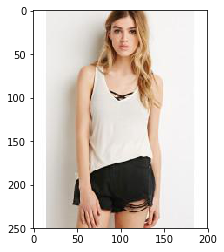

In [73]:
plt.imshow(image.img_to_array(image.load_img(np.random.choice(class_images_dict['Tank']))).astype('uint8'))
plt.show()

In [6]:
new_category_map = {'Anorak':'0','bomber':'0','Jacket':'0','Parka':'0', #Anorak, bomber, jacket,parka
                    'Cardigan':'1', #Cardigan
                    'Sweater':'2',#sweater
                    'Tank':'3',#Tank
                    'Blouse':'4',#blouse
                    'Tee':'5'#Tee
                   }

In [7]:
total_images = []
for c in class_images_dict.keys():
    cur_class_list = class_images_dict[c]
    temp_array = []
    for idx,img_path in enumerate(cur_class_list[:5000]):
        temp = cur_class_list[idx]
        #cur_class_list[idx]= img_path+'+'+ new_category_map[c]
        temp = img_path + '+' + new_category_map[c]
        temp_array.append(temp)
    total_images += temp_array

In [8]:
total_images = shuffle(total_images)

In [9]:
len(total_images)

30836

In [10]:
total_images = [item.split('+') for item in total_images]

In [11]:
total_images[:5]

[['/home/daviesodu/sb-capstone/dataset/Img/img/Lace-Back_Henley_Tank/img_00000056.jpg',
  '3'],
 ['/home/daviesodu/sb-capstone/dataset/Img/img/Hooded_Cotton_Canvas_Anorak/img_00000136.jpg',
  '0'],
 ['/home/daviesodu/sb-capstone/dataset/Img/img/Dotted_Bow_Blouse/img_00000005.jpg',
  '4'],
 ['/home/daviesodu/sb-capstone/dataset/Img/img/Heart_Printed_Tie-Neck_Blouse/img_00000113.jpg',
  '4'],
 ['/home/daviesodu/sb-capstone/dataset/Img/img/Metallic_Polka_Dot_Blouse/img_00000068.jpg',
  '4']]

In [12]:
X_t,y_t = zip(*total_images)

In [13]:
#X_tt = X_t[:500]
#y_tt = y_t[:500]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, test_size=0.33, random_state=42)

In [15]:
len(X_train)

20660

In [16]:
train_path_from = os.path.abspath('./dataset/Img/img/')
valid_path_from = os.path.abspath('./dataset/Img/img/')

train_path_to = os.path.abspath('./dataset/modified_new/Training')
valid_path_to = os.path.abspath('./dataset/modified_new/Validation')

mkdir(train_path_to)
mkdir(valid_path_to)

In [20]:
arr = glob('./dataset/modified_new/Training/*/*')
for a in arr:
    os.unlink(a)
print()

In [21]:
for img_path in X_train:
    img_class=img_path.split('/')[7].split('_')[-1]
    src = img_path
    dst = train_path_to + '/' + new_category_map[img_class] + '/'+ ''.join(img_path.split('/')[7:])
    if os.path.exists(src):
        link(src, dst)
    else:
        os.unlink(dst)

In [22]:
for img_path in X_test:
    img_class=img_path.split('/')[7].split('_')[-1]
    src = img_path
    dst = valid_path_to +'/' + new_category_map[img_class] + '/'+ ''.join(img_path.split('/')[7:])
    if os.path.exists(src):
        link(src, dst)
    else:
        os.unlink(dst)

In [23]:
len(X_test)

10176

In [24]:
#glob('./dataset/modified_new/Training/*/*')

In [25]:
train_links = glob('./dataset/modified_new/Training/*/*')
val_links = glob('./dataset/modified_new/Validation/*/*')
assert(len(train_links)==len(X_train))
assert(len(val_links)==len(X_test))

In [26]:
p = X_train[0]
imgg = image.img_to_array(image.load_img(p))
imgg.shape

(300, 205, 3)

In [27]:
#glob('/home/daviesodu/sb-capstone/dataset/modified_new/Training/0/*')

## Image cropping and generator instantiation

In [28]:
# re-size all the images to this
#IMAGE_SIZE = [100, 100]
IMAGE_SIZE = [100, 100]

# training config:
epochs = 10
batch_size = 128

# useful for getting number of files
image_files = glob(train_path_to +'//*//*.jp*g')
valid_image_files = glob(valid_path_to + '//*//*.jp*g')

In [29]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rescale=1./255,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

In [30]:
def get_bbox(bbox_file_path):
    rf = open(bbox_file_path).readlines()[2:]
    
    bboxes = {}
    for l in tqdm_notebook(range(len(rf))):
        info = rf[l].strip('\n').split(' ')
        img_path = '/home/daviesodu/sb-capstone/dataset/Img/'+info[0]
        bbox = info[-4:]
        bboxes[img_path]=[int(val) for val in bbox]
    return bboxes

In [31]:
def create_rescaled_bbox(bboxes, tot_paths):
    #bboxes - map of img_path->bbox
    #use img_path to get img_dimension
    #add entry of new_bbox to each image
    for k,v in tqdm_notebook(bboxes.items()):
        bbox = v
        if k in tot_paths:
            try:
                img = image.img_to_array(image.load_img(k))
                old_y, old_x, _= img.shape
                r_x = 256/old_x
                r_y=256/old_y
                new_bbox =  [bbox[0]*r_x, bbox[1]*r_y, bbox[2]*r_x, bbox[3]*r_y]
                bboxes[k] += new_bbox
            except:
                pass
    return bboxes

In [32]:
bboxes= get_bbox('./dataset/Anno/list_bbox.txt')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [33]:
train_data = glob('./dataset/modified_new/Training/*/*')
val_data = glob('./dataset/modified_new/Validation/*/*')
tot_paths = train_data+val_data
tot_paths = [os.readlink(p) for p in tot_paths]

In [ ]:
scaled_bboxes = create_rescaled_bbox(bboxes, tot_paths)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [35]:
def random_crop(img, bbox, image_dim):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    x_1, y_1, x_2, y_2 = bbox
    
    # resize bounding box, first get scale ratio
    x_scale = image_dim / img.shape[1]
    y_scale = image_dim / img.shape[0]
    
    img = cv2.resize(img, (image_dim,image_dim), cv2.INTER_CUBIC)
    #img = img/255.0
    
    #print(x_scale,y_scale)
    
    x_1=int(np.round(x_1*x_scale))
    y_1=int(np.round(y_1*y_scale))
    x_2=int(np.round(x_2*x_scale))
    y_2=int(np.round(y_2*y_scale))
    
    #print(img.shape)
    
    img_crop = img[y_1: y_2, x_1:x_2]
    img_crop = cv2.resize(img_crop, (image_dim,image_dim), cv2.INTER_CUBIC)
    return img_crop

In [36]:
def drawBox(img, bbb):
    x_1, y_1, x_2, y_2 = bbb
    plt.imshow(img)
    plt.gca().add_patch(Rectangle((x_1,y_2),x_2-x_1,y_1-y_2,linewidth=1,edgecolor='r',facecolor='none'))
    plt.show()

In [129]:
#Test crop
path = tot_paths[500]
bbb = bboxes[path]
imgg = cv2.imread(path)
old_y, old_x, _= imgg.shape
r_x = 256/old_x
r_y=256/old_y
imgg = cv2.resize(imgg, (256,256), cv2.INTER_CUBIC)

In [130]:
newImg = random_crop(imgg,bbb,100)

## Rewrite bounding box according to new ratio

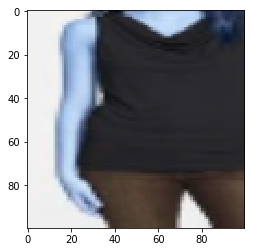

In [131]:
plt.imshow(newImg)

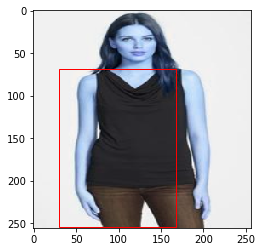

In [132]:
drawBox(imgg,bbb)

## Test crop method

In [51]:
def crop_generator(batches, bboxes, image_dim):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    bbox_index = 0
    
    while True:
        batch_x, batch_y = next(batches) 
        l = batch_x.shape[0] #20
        bboxes_batch = bboxes[bbox_index:bbox_index+l] #[0:20],[20:40]
        bbox_index = l
        batch_crops = np.zeros((batch_x.shape[0], image_dim, image_dim, 3))
        for i in range(batch_x.shape[0]):
            #batch_crops[i] = random_crop(batch_x[i], bboxes_batch[i][4:], image_dim)
            batch_crops[i] = random_crop(batch_x[i], bboxes_batch[i], image_dim)
        yield (batch_crops, batch_y)

## Load bounding box information

In [44]:
# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path_to)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k    

Found 10176 images belonging to 6 classes.


In [45]:
def get_path_bbox(symlink_dest_array, bboxes):
    #res contains a list of bboxes, ordered according to train or test data
    res =[]
    for dest in symlink_dest_array:
        src_path=os.readlink(dest)
        bbox = bboxes[src_path]
        res.append(bbox)
    return res

In [47]:
val_bboxes = get_path_bbox(val_links,bboxes)
train_bboxes = get_path_bbox(train_links,bboxes)

In [52]:
test_crops = crop_generator(test_gen,val_bboxes, IMAGE_SIZE[0])

In [53]:
len(train_bboxes)

20660

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


here
min: -0.24673952162265778 max: 0.5923961400985718
(100, 100, 3)


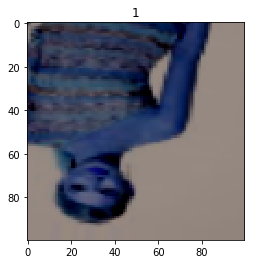

In [135]:
# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_crops:
    print('here')
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    print(x[0].shape)
    plt.imshow(x[0])
    plt.show()
    break

In [134]:
# create generators
train_generator = gen.flow_from_directory(
  train_path_to,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path_to,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 20660 images belonging to 6 classes.
Found 10176 images belonging to 6 classes.


# Compile Model

In [56]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [61]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [65]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)
x = Dense(4096, activation='relu', )(x)
x = Dropout(0.5)(x)
prediction = Dense(6, activation='softmax')(x)

In [67]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [68]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0   

# fit model

In [70]:
# fit the model
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=20,
  steps_per_epoch=len(image_files) // batch_size,
  validation_steps=len(valid_image_files) // batch_size,
)

Epoch 1/20
161/161 [==============================] - 98s 609ms/step - loss: 1.3625 - accuracy: 0.4678 - val_loss: 1.5269 - val_accuracy: 0.4673
Epoch 2/20
161/161 [==============================] - 98s 611ms/step - loss: 1.3616 - accuracy: 0.4699 - val_loss: 1.2272 - val_accuracy: 0.4691
Epoch 3/20
161/161 [==============================] - 99s 612ms/step - loss: 1.3595 - accuracy: 0.4704 - val_loss: 1.3830 - val_accuracy: 0.4791
Epoch 4/20
161/161 [==============================] - 100s 619ms/step - loss: 1.3550 - accuracy: 0.4738 - val_loss: 1.3834 - val_accuracy: 0.4806
Epoch 5/20
161/161 [==============================] - 99s 612ms/step - loss: 1.3621 - accuracy: 0.4727 - val_loss: 1.3985 - val_accuracy: 0.4720
Epoch 6/20
161/161 [==============================] - 98s 609ms/step - loss: 1.3536 - accuracy: 0.4731 - val_loss: 1.2629 - val_accuracy: 0.4777
Epoch 7/20
161/161 [==============================] - 98s 609ms/step - loss: 1.3528 - accuracy: 0.4792 - val_loss: 1.2236 - val_a

# accuracy analysis

In [71]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

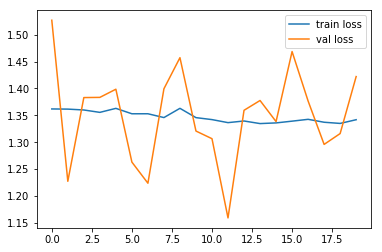

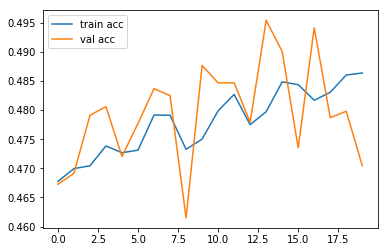

In [72]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()